# Import em1d

In [1]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

import em1d as zpic
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation, FFMpegWriter
import os

# nx test

In [ ]:
#nx = 100   # Number of cells in the x direction
#box = 10   # Size of the box
#dx = box / nx

box = 50

#dt = 0.05  # Time step between each iteration 
ppc = 1000 # Particles per cell


# Initialize the velocities before the simulation
uth = [0.0,0.0,0.0] # Initial thermal velocity
ufl = [0.0,0.0,0.0] # Initial fluid velocity

# Dispersion relation
k = 5 * 2*np.pi/box  # box = 5 * lambda
print(f'k = {k}')
omega_p = 1

def omega(x):
    return np.sqrt(1 + (3/2*x**2*uth[0]**2)/omega_p**2)


# Density profile
n0 = 1
n1 = 0.001
def custom_n(x):
    return n0 + n1*np.cos(k*x)

density = zpic.Density( type = "custom", custom = custom_n )

nx_values = np.linspace(100, 1000, num=10)

for nx in nx_values:

    dt = 25/nx

    print(dt/(box/nx))

    electrons = zpic.Species("electrons", -1.0, ppc, density=density, uth=uth, ufl=ufl, bc_type="periodic")
    sim = zpic.Simulation( nx, box = box, dt = dt, species = electrons )

    electrons.n_sort = 0

    # Magnetic field
    B_ext = zpic.InitialField(B_type = 'none')

    sim.emf.init_fld( B_ext )


    #Electric field
    def E1_field( ix, dx ):
        # Ex is located at the center of the cell
        x = (ix+0.5)*dx
        E1 = -n1/k
        return [E1*np.sin(k*x - omega(k)*sim.t),0,0]

    E_ext = zpic.InitialField(E_type = 'custom', E_custom = E1_field )

    sim.emf.init_fld( E_ext )

    def v1(x):
        return omega(k)/k * n1 * np.cos(k*x)

    for particle in electrons.particles:
        pos = (particle['ix'] + particle['x']) * sim.dx
        particle['ux'] = v1(pos)

    # Run the simulation

    ''' We run the simulation up to a fixed number of iterations, controlled by the variable `niter`,
    storing the values of n and E at every timestep so we can analyze them later. '''
    niter = int(3000/dt)
    Ex_t = np.zeros((niter,sim.nx))
    n_t = np.zeros((niter,sim.nx))

    print("\nRunning simulation up to t = {:g} ...".format(niter * sim.dt))
    while sim.n < niter:
        print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
        Ex_t[sim.n,:] = sim.emf.Ex
        n_t[sim.n,:] =  np.abs(electrons.charge())
        sim.iter()

    print("\nDone.")

    # Movie parameters
    nframes = 1000*1.5
    fps = 16

    # Increase the embed limit if the movie is large
    import matplotlib
    matplotlib.rcParams['animation.embed_limit'] = 128

    # Create plots
    x_vals = np.linspace(0, sim.box, sim.nx)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 10))
    ax1.set_xlim((0, sim.box))
    ax1.set_ylim((0.997, 1.003))
    ax2.set_xlim((0, sim.box))
    ax2.set_ylim((-0.002, 0.002))


    line1, = ax1.plot([], [], lw=2, color='blue')
    line2, = ax2.plot([], [], lw=2, color='orange')

    ax1.set_xlabel(r"$x$")
    ax1.set_ylabel(r"$n(x)$")

    ax2.set_xlabel(r"$x$")
    ax2.set_ylabel(r"$E_1(x)$")

    # Animation function
    def animate(i):
        time_index = int(i * len(Ex_t) / nframes)  # Map frame to time index in Ex_t and n_t
        line1.set_data(x_vals, n_t[time_index, :]) 
        line2.set_data(x_vals, Ex_t[time_index, :])
        ax1.set_title(f"Density $n$ at t = {time_index * sim.dt:.2f}")
        ax2.set_title(f"Electric Field $E_1$ at t = {time_index * sim.dt:.2f}")
        return (line1, line2)

    # Create the movie
    #anim = animation.FuncAnimation(fig, animate, frames=nframes, repeat=False, blit=True, interval=1000.0 / fps)

    output_folder = "simulation_videos"
    os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist
    output_path = os.path.join(output_folder, f"nx={nx}.mp4")

    # Save the animation
    writer = FFMpegWriter(fps=fps, metadata={"title": "Simulation", "artist": "YourName"})
    with writer.saving(fig, output_path, dpi=100):
        for i in range(int(nframes)):
            animate(i)  # Update frame
            writer.grab_frame()


    # Show the completed movie
    #plt.close()
    #HTML(anim.to_html5_video())


# dt test

In [ ]:
#nx = 100   # Number of cells in the x direction
#box = 10   # Size of the box
#dx = box / nx

box = 50
nx = 1000
dx = box / nx
dt_courant = 1 / np.sqrt(1.0/dx**2)
ppc = 1000 # Particles per cell


# Initialize the velocities before the simulation
uth = [0.0,0.0,0.0] # Initial thermal velocity
ufl = [0.0,0.0,0.0] # Initial fluid velocity

# Dispersion relation
k = 5 * 2*np.pi/box  # box = 5 * lambda
print(f'k = {k}')
omega_p = 1

def omega(x):
    return np.sqrt(1 + (3/2*x**2*uth[0]**2)/omega_p**2)


# Density profile
n0 = 1
n1 = 0.001
def custom_n(x):
    return n0 + n1*np.cos(k*x)

density = zpic.Density( type = "custom", custom = custom_n )

dt_values = [0.1*dt_courant, 0.2*dt_courant, 0.3*dt_courant, 0.4*dt_courant,
            0.5*dt_courant, 0.6*dt_courant, 0.7*dt_courant, 0.8*dt_courant, 0.9*dt_courant]

for dt in dt_values:

    electrons = zpic.Species("electrons", -1.0, ppc, density=density, uth=uth, ufl=ufl, bc_type="periodic")
    sim = zpic.Simulation( nx, box = box, dt = dt, species = electrons )

    electrons.n_sort = 0

    # Magnetic field
    B_ext = zpic.InitialField(B_type = 'none')

    sim.emf.init_fld( B_ext )


    #Electric field
    def E1_field( ix, dx ):
        # Ex is located at the center of the cell
        x = (ix+0.5)*dx
        E1 = -n1/k
        return [E1*np.sin(k*x - omega(k)*sim.t),0,0]

    E_ext = zpic.InitialField(E_type = 'custom', E_custom = E1_field )

    sim.emf.init_fld( E_ext )

    def v1(x):
        return omega(k)/k * n1 * np.cos(k*x)

    for particle in electrons.particles:
        pos = (particle['ix'] + particle['x']) * sim.dx
        particle['ux'] = v1(pos)

    # Run the simulation

    ''' We run the simulation up to a fixed number of iterations, controlled by the variable `niter`,
    storing the values of n and E at every timestep so we can analyze them later. '''
    niter = int(3000/dt)
    Ex_t = np.zeros((niter,sim.nx))
    n_t = np.zeros((niter,sim.nx))

    print("\nRunning simulation up to t = {:g} ...".format(niter * sim.dt))
    while sim.n < niter:
        print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
        Ex_t[sim.n,:] = sim.emf.Ex
        n_t[sim.n,:] =  np.abs(electrons.charge())
        sim.iter()

    print("\nDone.")

    # Movie parameters
    nframes = 1000*1.5
    fps = 16

    # Increase the embed limit if the movie is large
    import matplotlib
    matplotlib.rcParams['animation.embed_limit'] = 128

    # Create plots
    x_vals = np.linspace(0, sim.box, sim.nx)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 10))
    ax1.set_xlim((0, sim.box))
    ax1.set_ylim((0.997, 1.003))
    ax2.set_xlim((0, sim.box))
    ax2.set_ylim((-0.002, 0.002))


    line1, = ax1.plot([], [], lw=2, color='blue')
    line2, = ax2.plot([], [], lw=2, color='orange')

    ax1.set_xlabel(r"$x$")
    ax1.set_ylabel(r"$n(x)$")

    ax2.set_xlabel(r"$x$")
    ax2.set_ylabel(r"$E_1(x)$")

    # Animation function
    def animate(i):
        time_index = int(i * len(Ex_t) / nframes)  # Map frame to time index in Ex_t and n_t
        line1.set_data(x_vals, n_t[time_index, :])
        line2.set_data(x_vals, Ex_t[time_index, :])
        ax1.set_title(f"Density $n$ at t = {time_index * sim.dt:.2f}")
        ax2.set_title(f"Electric Field $E_1$ at t = {time_index * sim.dt:.2f}")
        return (line1, line2)

    # Create the movie
    #anim = animation.FuncAnimation(fig, animate, frames=nframes, repeat=False, blit=True, interval=1000.0 / fps)

    output_folder = "simulation_videos"
    os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist
    output_path = os.path.join(output_folder, f"dt={dt}_nx={nx}.mp4")

    # Save the animation
    writer = FFMpegWriter(fps=fps, metadata={"title": "Simulation", "artist": "YourName"})
    with writer.saving(fig, output_path, dpi=100):
        for i in range(int(nframes)):
            animate(i)  # Update frame
            writer.grab_frame()


    # Show the completed movie
    #plt.close()
    #HTML(anim.to_html5_video())


# box test

In [ ]:
#nx = 100   # Number of cells in the x direction
#box = 10   # Size of the box
#dx = box / nx

ppc = 1000 # Particles per cell


# Initialize the velocities before the simulation
uth = [0.0,0.0,0.0] # Initial thermal velocity
ufl = [0.0,0.0,0.0] # Initial fluid velocity

# Dispersion relation
#k = 5 * 2*np.pi/box  # box = 5 * lambda
omega_p = 1

def omega(x):
    return np.sqrt(1 + (3/2*x**2*uth[0]**2)/omega_p**2)


# Density profile
n0 = 1
n1 = 0.001
def custom_n(x):
    return n0 + n1*np.cos(k*x)

density = zpic.Density( type = "custom", custom = custom_n )

#box_values = np.linspace(10, 100, 10)
box_values = [80, 90, 100]

for box in box_values:

    nx = box / 0.05
    dx = box / nx
    print(dx)

    k = 5 * 2*np.pi/box

    dt = 0.99 * dx

    electrons = zpic.Species("electrons", -1.0, ppc, density=density, uth=uth, ufl=ufl, bc_type="periodic")
    sim = zpic.Simulation( nx, box = box, dt = dt, species = electrons )

    electrons.n_sort = 0

    # Magnetic field
    B_ext = zpic.InitialField(B_type = 'none')

    sim.emf.init_fld( B_ext )


    #Electric field
    def E1_field( ix, dx ):
        # Ex is located at the center of the cell
        x = (ix+0.5)*dx
        E1 = -n1/k
        return [E1*np.sin(k*x - omega(k)*sim.t),0,0]

    E_ext = zpic.InitialField(E_type = 'custom', E_custom = E1_field )

    sim.emf.init_fld( E_ext )

    def v1(x):
        return omega(k)/k * n1 * np.cos(k*x)

    for particle in electrons.particles:
        pos = (particle['ix'] + particle['x']) * sim.dx
        particle['ux'] = v1(pos)

    # Run the simulation

    ''' We run the simulation up to a fixed number of iterations, controlled by the variable `niter`,
    storing the values of n and E at every timestep so we can analyze them later. '''
    niter = int(3000/dt)
    Ex_t = np.zeros((niter,sim.nx))
    n_t = np.zeros((niter,sim.nx))

    print("\nRunning simulation up to t = {:g} ...".format(niter * sim.dt))
    while sim.n < niter:
        print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
        Ex_t[sim.n,:] = sim.emf.Ex
        n_t[sim.n,:] =  np.abs(electrons.charge())
        sim.iter()

    print("\nDone.")

    # Movie parameters
    nframes = 1000*1.5
    fps = 16

    # Increase the embed limit if the movie is large
    import matplotlib
    matplotlib.rcParams['animation.embed_limit'] = 128

    # Create plots
    x_vals = np.linspace(0, sim.box, sim.nx)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 10))
    ax1.set_xlim((0, sim.box))
    ax1.set_ylim((0.997, 1.003))
    ax2.set_xlim((0, sim.box))
    #ax2.set_ylim((-0.002, 0.002))
    ax2.set_ylim((-n1/k * 1.3, n1/k * 1.3))

    line1, = ax1.plot([], [], lw=2, color='blue')
    line2, = ax2.plot([], [], lw=2, color='orange')

    ax1.set_xlabel(r"$x$")
    ax1.set_ylabel(r"$n(x)$")

    ax2.set_xlabel(r"$x$")
    ax2.set_ylabel(r"$E_1(x)$")

    # Animation function
    def animate(i):
        time_index = int(i * len(Ex_t) / nframes)  # Map frame to time index in Ex_t and n_t
        line1.set_data(x_vals, n_t[time_index, :])
        line2.set_data(x_vals, Ex_t[time_index, :])
        ax1.set_title(f"Density $n$ at t = {time_index * sim.dt:.2f}")
        ax2.set_title(f"Electric Field $E_1$ at t = {time_index * sim.dt:.2f}")
        return (line1, line2)

    # Create the movie
    #anim = animation.FuncAnimation(fig, animate, frames=nframes, repeat=False, blit=True, interval=1000.0 / fps)

    output_folder = "simulation_videos"
    os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist
    output_path = os.path.join(output_folder, f"box={box}_dx=0.05.mp4")

    # Save the animation
    writer = FFMpegWriter(fps=fps, metadata={"title": "Simulation", "artist": "YourName"})
    with writer.saving(fig, output_path, dpi=100):
        for i in range(int(nframes)):
            animate(i)  # Update frame
            writer.grab_frame()


    # Show the completed movie
    #plt.close()
    #HTML(anim.to_html5_video())


# box test with k = constant

In [ ]:
#nx = 100   # Number of cells in the x direction
#box = 10   # Size of the box
#dx = box / nx

ppc = 1000 # Particles per cell


# Initialize the velocities before the simulation
uth = [0.0,0.0,0.0] # Initial thermal velocity
ufl = [0.0,0.0,0.0] # Initial fluid velocity

# Dispersion relation
#k = 5 * 2*np.pi/box  # box = 5 * lambda
omega_p = 1

def omega(x):
    return np.sqrt(1 + (3/2*x**2*uth[0]**2)/omega_p**2)


# Density profile
n0 = 1
n1 = 0.001
def custom_n(x):
    return n0 + n1*np.cos(k*x)

density = zpic.Density( type = "custom", custom = custom_n )

box_values = np.linspace(10, 100, 10)

for box in box_values:

    nx = box / 0.05
    dx = box / nx
    print(dx)

    #k = 5 * 2*np.pi/box
    k = np.pi/5

    dt = 0.99 * dx

    electrons = zpic.Species("electrons", -1.0, ppc, density=density, uth=uth, ufl=ufl, bc_type="periodic")
    sim = zpic.Simulation( nx, box = box, dt = dt, species = electrons )

    electrons.n_sort = 0

    # Magnetic field
    B_ext = zpic.InitialField(B_type = 'none')

    sim.emf.init_fld( B_ext )


    #Electric field
    def E1_field( ix, dx ):
        # Ex is located at the center of the cell
        x = (ix+0.5)*dx
        E1 = -n1/k
        return [E1*np.sin(k*x - omega(k)*sim.t),0,0]

    E_ext = zpic.InitialField(E_type = 'custom', E_custom = E1_field )

    sim.emf.init_fld( E_ext )

    def v1(x):
        return omega(k)/k * n1 * np.cos(k*x)

    for particle in electrons.particles:
        pos = (particle['ix'] + particle['x']) * sim.dx
        particle['ux'] = v1(pos)

    # Run the simulation

    ''' We run the simulation up to a fixed number of iterations, controlled by the variable `niter`,
    storing the values of n and E at every timestep so we can analyze them later. '''
    niter = int(2000/dt)
    Ex_t = np.zeros((niter,sim.nx))
    n_t = np.zeros((niter,sim.nx))

    print("\nRunning simulation up to t = {:g} ...".format(niter * sim.dt))
    while sim.n < niter:
        print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
        Ex_t[sim.n,:] = sim.emf.Ex
        n_t[sim.n,:] =  np.abs(electrons.charge())
        sim.iter()

    print("\nDone.")

    # Movie parameters
    #nframes = 1000*1.5
    nframes = 1000
    fps = 16

    # Increase the embed limit if the movie is large
    import matplotlib
    matplotlib.rcParams['animation.embed_limit'] = 128

    # Create plots
    x_vals = np.linspace(0, sim.box, sim.nx)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 10))
    ax1.set_xlim((0, sim.box))
    ax1.set_ylim((0.997, 1.003))
    ax2.set_xlim((0, sim.box))
    #ax2.set_ylim((-0.002, 0.002))
    ax2.set_ylim((-n1/k * 1.3, n1/k * 1.3))

    line1, = ax1.plot([], [], lw=2, color='blue')
    line2, = ax2.plot([], [], lw=2, color='orange')

    ax1.set_xlabel(r"$x$")
    ax1.set_ylabel(r"$n(x)$")

    ax2.set_xlabel(r"$x$")
    ax2.set_ylabel(r"$E_1(x)$")

    # Animation function
    def animate(i):
        time_index = int(i * len(Ex_t) / nframes)  # Map frame to time index in Ex_t and n_t
        line1.set_data(x_vals, n_t[time_index, :])
        line2.set_data(x_vals, Ex_t[time_index, :])
        ax1.set_title(f"Density $n$ at t = {time_index * sim.dt:.2f}")
        ax2.set_title(f"Electric Field $E_1$ at t = {time_index * sim.dt:.2f}")
        return (line1, line2)

    # Create the movie
    #anim = animation.FuncAnimation(fig, animate, frames=nframes, repeat=False, blit=True, interval=1000.0 / fps)

    output_folder = "simulation_videos"
    os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist
    output_path = os.path.join(output_folder, f"box={box}_k=cte_dx=0.05.mp4")

    # Save the animation
    writer = FFMpegWriter(fps=fps, metadata={"title": "Simulation", "artist": "YourName"})
    with writer.saving(fig, output_path, dpi=100):
        for i in range(int(nframes)):
            animate(i)  # Update frame
            writer.grab_frame()


    # Show the completed movie
    #plt.close()
    #HTML(anim.to_html5_video())


# ppc test

In [ ]:
#nx = 100   # Number of cells in the x direction
#box = 10   # Size of the box
#dx = box / nx

box = 50
nx = 1000
dx = box / nx

dt_courant = 1 / np.sqrt(1.0/dx**2)
dt = 0.99 * dt_courant

k = 5 * 2*np.pi/box

# Initialize the velocities before the simulation
uth = [0.0,0.0,0.0] # Initial thermal velocity
ufl = [0.0,0.0,0.0] # Initial fluid velocity

# Dispersion relation
#k = 5 * 2*np.pi/box  # box = 5 * lambda
omega_p = 1

def omega(x):
    return np.sqrt(1 + (3/2*x**2*uth[0]**2)/omega_p**2)


# Density profile
n0 = 1
n1 = 0.001
def custom_n(x):
    return n0 + n1*np.cos(k*x)

density = zpic.Density( type = "custom", custom = custom_n )

ppc_values = np.linspace(100, 1000, 10)

for ppc in ppc_values:

    electrons = zpic.Species("electrons", -1.0, ppc, density=density, uth=uth, ufl=ufl, bc_type="periodic")
    sim = zpic.Simulation( nx, box = box, dt = dt, species = electrons )

    electrons.n_sort = 0

    # Magnetic field
    B_ext = zpic.InitialField(B_type = 'none')

    sim.emf.init_fld( B_ext )


    #Electric field
    def E1_field( ix, dx ):
        # Ex is located at the center of the cell
        x = (ix+0.5)*dx
        E1 = -n1/k
        return [E1*np.sin(k*x - omega(k)*sim.t),0,0]

    E_ext = zpic.InitialField(E_type = 'custom', E_custom = E1_field )

    sim.emf.init_fld( E_ext )

    def v1(x):
        return omega(k)/k * n1 * np.cos(k*x)

    for particle in electrons.particles:
        pos = (particle['ix'] + particle['x']) * sim.dx
        particle['ux'] = v1(pos)

    # Run the simulation

    ''' We run the simulation up to a fixed number of iterations, controlled by the variable `niter`,
    storing the values of n and E at every timestep so we can analyze them later. '''
    niter = int(3000/dt)
    Ex_t = np.zeros((niter,sim.nx))
    n_t = np.zeros((niter,sim.nx))

    print("\nRunning simulation up to t = {:g} ...".format(niter * sim.dt))
    while sim.n < niter:
        print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
        Ex_t[sim.n,:] = sim.emf.Ex
        n_t[sim.n,:] =  np.abs(electrons.charge())
        sim.iter()

    print("\nDone.")

    # Movie parameters
    nframes = 1000*1.5
    fps = 16

    # Increase the embed limit if the movie is large
    import matplotlib
    matplotlib.rcParams['animation.embed_limit'] = 128

    # Create plots
    x_vals = np.linspace(0, sim.box, sim.nx)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 10))
    ax1.set_xlim((0, sim.box))
    ax1.set_ylim((0.997, 1.003))
    ax2.set_xlim((0, sim.box))
    #ax2.set_ylim((-0.002, 0.002))
    ax2.set_ylim((-n1/k * 1.3, n1/k * 1.3))

    line1, = ax1.plot([], [], lw=2, color='blue')
    line2, = ax2.plot([], [], lw=2, color='orange')

    ax1.set_xlabel(r"$x$")
    ax1.set_ylabel(r"$n(x)$")

    ax2.set_xlabel(r"$x$")
    ax2.set_ylabel(r"$E_1(x)$")

    # Animation function
    def animate(i):
        time_index = int(i * len(Ex_t) / nframes)  # Map frame to time index in Ex_t and n_t
        line1.set_data(x_vals, n_t[time_index, :])
        line2.set_data(x_vals, Ex_t[time_index, :])
        ax1.set_title(f"Density $n$ at t = {time_index * sim.dt:.2f}")
        ax2.set_title(f"Electric Field $E_1$ at t = {time_index * sim.dt:.2f}")
        return (line1, line2)

    # Create the movie
    #anim = animation.FuncAnimation(fig, animate, frames=nframes, repeat=False, blit=True, interval=1000.0 / fps)

    output_folder = "simulation_videos"
    os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist
    output_path = os.path.join(output_folder, f"ppc={ppc}_dx=0.05.mp4")

    # Save the animation
    writer = FFMpegWriter(fps=fps, metadata={"title": "Simulation", "artist": "YourName"})
    with writer.saving(fig, output_path, dpi=100):
        for i in range(int(nframes)):
            animate(i)  # Update frame
            writer.grab_frame()


    # Show the completed movie
    #plt.close()
    #HTML(anim.to_html5_video())


# Phase space evolution

dt = 0.0495
k = 0.6283185307179586
0.015915494

Running simulation up to t = 3000 ...

Done.


/var/folders/4w/pn1qx9f52s9ff1qdz7_zxp680000gn/T/ipykernel_62143/215282243.py:139: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  writer.grab_frame()


Animation saved.


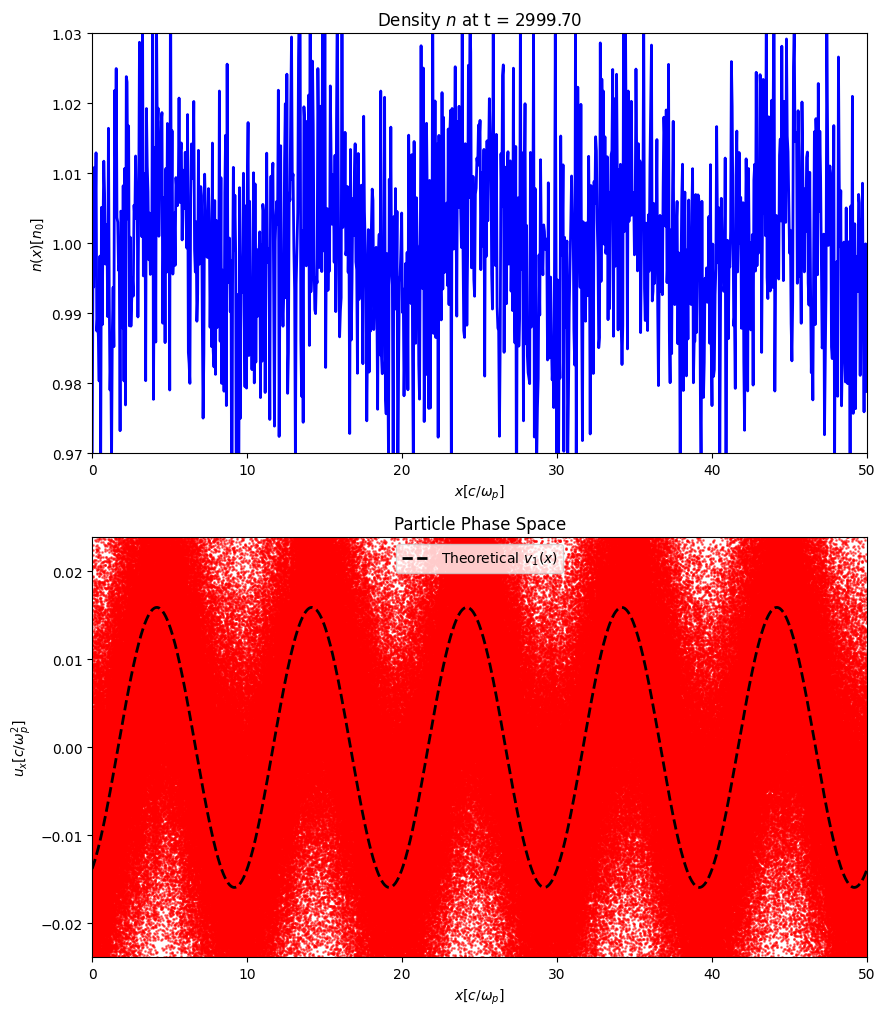

In [ ]:
box = 50
nx = 1000
dx = box / nx

dt_courant = 1 / np.sqrt(1.0/dx**2)
dt = 0.99 * dt_courant

print(f"dt = {dt}")

ppc = 1000 # Particles per cell


# Initialize the velocities before the simulation
uth = [0.0,0.0,0.0] # Initial thermal velocity
ufl = [0.0,0.0,0.0] # Initial fluid velocity

# Dispersion relation
k = 5 * 2*np.pi/box  # box = 5 * lambda
print(f'k = {k}')
omega_p = 1

def omega(x):
    return np.sqrt(1 + (3/2*x**2*uth[0]**2)/omega_p**2)

# Density profile
#n0 = 1
n1 = 0.001
n1 = 0.01
def custom_n(x):
    return n0 + n1*np.cos(k*x)

density = zpic.Density( type = "custom", custom = custom_n )


electrons = zpic.Species("electrons", -1.0, ppc, density=density, uth=uth, ufl=ufl, bc_type="periodic")
sim = zpic.Simulation( nx, box = box, dt = dt, species = electrons )

electrons.n_sort = 0

# Magnetic field
B_ext = zpic.InitialField(B_type = 'none')

sim.emf.init_fld( B_ext )


#Electric field
def E1_field( ix, dx ):
    # Ex is located at the center of the cell
    x = (ix+0.5)*dx
    E1 = -n1/k
    return [E1*np.sin(k*x - omega(k)*sim.t),0,0]

E_ext = zpic.InitialField(E_type = 'custom', E_custom = E1_field )

sim.emf.init_fld( E_ext )

def v1(x):
    return omega(k)/k * n1 * np.cos(k*x)

for particle in electrons.particles:
    pos = (particle['ix'] + particle['x']) * sim.dx
    particle['ux'] = v1(pos)

# Find Vmax

vmax = np.max(np.abs(electrons.particles['ux']))
print(vmax)

def v1_theory(x):
    return omega(k)/k * n1 * np.cos(k*x - omega(k)*sim.t)

# Run the simulation

''' We run the simulation up to a fixed number of iterations, controlled by the variable `niter`,
storing the values of n and E at every timestep so we can analyze them later. '''
tmax = 3000
niter = int(tmax / sim.dt)
save_interval = 40  # Save every 40 iterations to reduce memory usage
saved_steps = (niter // save_interval) + 1  # Fix index out-of-bounds error

x_vals = np.linspace(0, sim.box, sim.nx)

Ex_t = np.zeros((saved_steps, sim.nx))
n_t = np.zeros((saved_steps, sim.nx))
v_theory_t = np.zeros((saved_steps, sim.nx))
particle_x_t = np.zeros((saved_steps, electrons.particles.shape[0]))
particle_ux_t = np.zeros((saved_steps, electrons.particles.shape[0]))

print("\nRunning simulation up to t = {:g} ...".format(niter * sim.dt))
saved_index = 0
while sim.n < niter:
    if sim.n % save_interval == 0 and saved_index < saved_steps:
        Ex_t[saved_index, :] = sim.emf.Ex
        n_t[saved_index, :] = np.abs(electrons.charge())
        v_theory_t[saved_index, :] = v1_theory(x_vals)
        particle_x_t[saved_index, :] = (electrons.particles['ix'] + electrons.particles['x']) * sim.dx
        particle_ux_t[saved_index, :] = electrons.particles['ux']
        saved_index += 1
    sim.iter()

print("\nDone.")

nframes = saved_steps
fps = 16

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
ax1.set_xlim((0, sim.box))
ax1.set_ylim((0.997, 1.003))
#ax1.set_ylim((0.97, 1.03))
ax2.set_xlim((0, sim.box))
#ax2.set_ylim((-vmax * 1.5, vmax * 1.5))
ax2.set_ylim((-0.004, 0.004))

line1, = ax1.plot([], [], lw=2, color='blue')
scat2 = ax2.scatter([], [], s=1, alpha=0.5, color='red')
line2, = ax2.plot([], [], lw=2, color='black', linestyle='dashed', label='Theoretical $v_1(x)$')
ax2.legend()
ax1.set_xlabel(r"$x [c/\omega_p]$")
ax1.set_ylabel(r"$n(x) [n_0]$")
ax2.set_xlabel(r"$x [c/\omega_p]$")
ax2.set_ylabel(r"$u_x [c/\omega_p^2]$")
ax2.set_title("Particle Phase Space")

def animate(i):
    line1.set_data(x_vals, n_t[i, :])
    ax1.set_title(f"Density $n$ at t = {i * save_interval * sim.dt:.2f}")
    scat2.set_offsets(np.c_[particle_x_t[i, :], particle_ux_t[i, :]])
    line2.set_data(x_vals, v_theory_t[i, :])
    return line1, scat2, line2

output_folder = "simulation_videos"
os.makedirs(output_folder, exist_ok=True)
output_path = os.path.join(output_folder, f"phase_space_evolution_nx={nx}_box={box}_dt=0.99dx.mp4")

writer = FFMpegWriter(fps=fps, metadata={"title": "Phase Space Evolution", "artist": "YourName"})
with writer.saving(fig, output_path, dpi=100):
    for i in range(nframes):
        animate(i)
        writer.grab_frame()

print("Animation saved.")


# Kinetic energy and E field placement test

k = 0.6283185307179586

Running simulation up to t = 3000 ...
Kinetic energy = 0.6225299835205078 at \omega_pt = 1 for index = 0.5
Kinetic energy = 0.61965012550354 at \omega_pt = 99 for index = 0.5
Kinetic energy = 0.6465619206428528 at \omega_pt = 499 for index = 0.5
Kinetic energy = 0.6482043266296387 at \omega_pt = 999 for index = 0.5
Kinetic energy = 0.6326490044593811 at \omega_pt = 1800 for index = 0.5
Kinetic energy = 0.6346167922019958 at \omega_pt = 1999 for index = 0.5
Kinetic energy = 0.6494874358177185 at \omega_pt = 2499 for index = 0.5
Kinetic energy = 0.6785597205162048 at \omega_pt = 2999 for index = 0.5

Done.


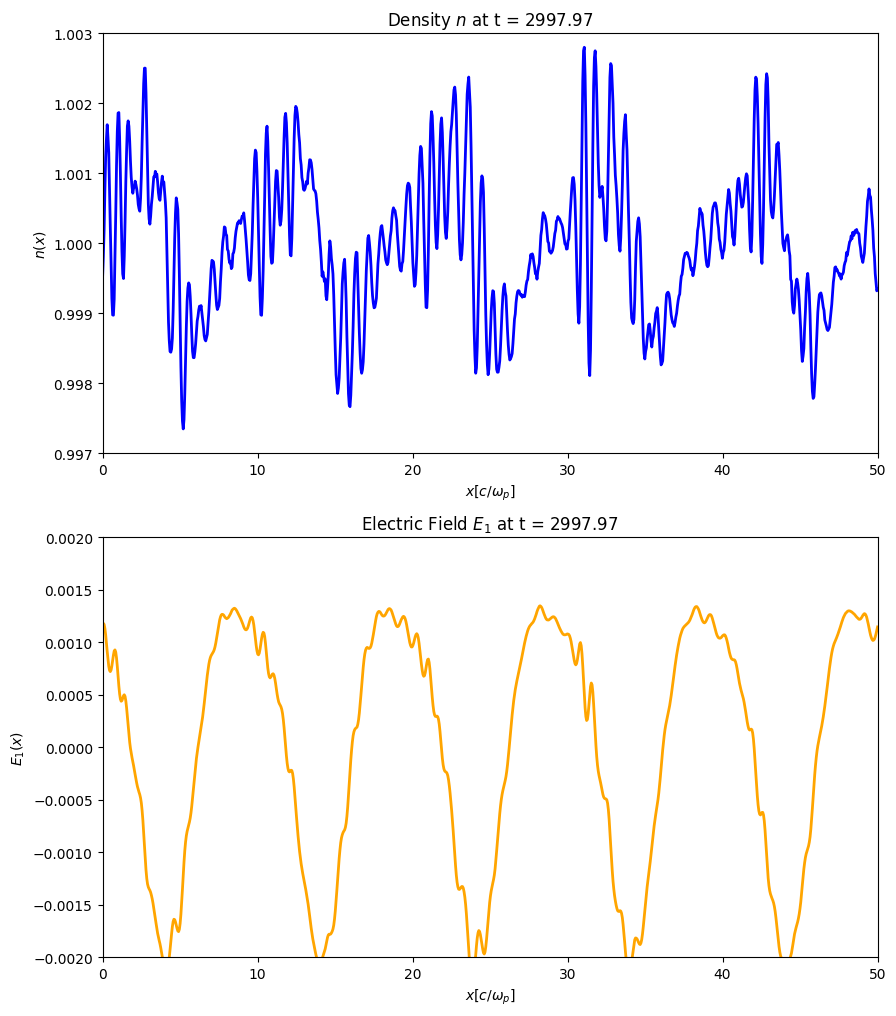

In [2]:
box = 50
nx = 1000
dx = box / nx

dt_courant = 1 / np.sqrt(1.0/dx**2)
dt = 0.99 * dt_courant
ppc = 1000 # Particles per cell

# Initialize the velocities before the simulation
uth = [0.0,0.0,0.0] # Initial thermal velocity
ufl = [0.0,0.0,0.0] # Initial fluid velocity

# Dispersion relation
k = 5 * 2*np.pi/box  # box = 5 * lambda
print(f'k = {k}')
omega_p = 1

def omega(x):
    return np.sqrt(1 + (3/2*x**2*uth[0]**2)/omega_p**2)


# Density profile
n0 = 1
n1 = 0.001
def custom_n(x):
    return n0 + n1*np.cos(k*x)

density = zpic.Density( type = "custom", custom = custom_n )
electrons = zpic.Species("electrons", -1.0, ppc, density=density, uth=uth, ufl=ufl, bc_type="periodic")

#index_values = [0, 0.5, 1]
index_values = [0.5]

for index in index_values:

    sim = zpic.Simulation( nx, box = box, dt = dt, species = electrons )

    electrons.n_sort = 0

    # Magnetic field
    B_ext = zpic.InitialField(B_type = 'none')

    sim.emf.init_fld( B_ext )

    t2_range = [2-sim.dt/2, 2+sim.dt/2]
    t100_range = [100-sim.dt/2, 100+sim.dt/2]
    t500_range = [500-sim.dt/2, 500+sim.dt/2]
    t1000_range = [1000-sim.dt/2, 1000+sim.dt/2]
    t1800_range = [1800-sim.dt/2, 1800+sim.dt/2]
    t2000_range = [2000-sim.dt/2, 2000+sim.dt/2]
    t2500_range = [2500-sim.dt/2, 2500+sim.dt/2]
    t3000_range = [3000-sim.dt/2, 3000+sim.dt/2]

    #Electric field
    def E1_field( ix, dx ):
        # Ex is located at the center of the cell
        x = (ix+index)*dx
        E1 = -n1/k
        return [E1*np.sin(k*x - omega(k)*sim.t),0,0]

    E_ext = zpic.InitialField(E_type = 'custom', E_custom = E1_field )

    sim.emf.init_fld( E_ext )

    def v1(x):
        return omega(k)/k * n1 * np.cos(k*x)

    for particle in electrons.particles:
        pos = (particle['ix'] + particle['x']) * sim.dx
        particle['ux'] = v1(pos)

    # Run the simulation

    ''' We run the simulation up to a fixed number of iterations, controlled by the variable `niter`,
    storing the values of n and E at every timestep so we can analyze them later. '''
    niter = int(3000/dt)
    Ex_t = np.zeros((niter,sim.nx))
    n_t = np.zeros((niter,sim.nx))

    print("\nRunning simulation up to t = {:g} ...".format(niter * sim.dt))
    while sim.n < niter:
        print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
        Ex_t[sim.n,:] = sim.emf.Ex
        n_t[sim.n,:] =  np.abs(electrons.charge())
        sim.iter()

        if sim.t >= t2_range[0] and sim.t <= t2_range[1]:
            kinetic_energy = 0
            for particle in electrons.particles:
                kinetic_energy += 0.5*(particle['ux'])**2
            print(f"Kinetic energy = {kinetic_energy} at \omega_pt = {int(sim.t)} for index = {index}")

        if sim.t >= t100_range[0] and sim.t <= t100_range[1]:
            kinetic_energy = 0
            for particle in electrons.particles:
                kinetic_energy += 0.5*(particle['ux'])**2
            print(f"Kinetic energy = {kinetic_energy} at \omega_pt = {int(sim.t)} for index = {index}")

        if sim.t >= t500_range[0] and sim.t <= t500_range[1]:
            kinetic_energy = 0
            for particle in electrons.particles:
                kinetic_energy += 0.5*(particle['ux'])**2
            print(f"Kinetic energy = {kinetic_energy} at \omega_pt = {int(sim.t)} for index = {index}")

        if sim.t >= t1000_range[0] and sim.t <= t1000_range[1]:
            kinetic_energy = 0
            for particle in electrons.particles:
                kinetic_energy += 0.5*(particle['ux'])**2
            print(f"Kinetic energy = {kinetic_energy} at \omega_pt = {int(sim.t)} for index = {index}")

        if sim.t >= t1800_range[0] and sim.t <= t1800_range[1]:
            kinetic_energy = 0
            for particle in electrons.particles:
                kinetic_energy += 0.5*(particle['ux'])**2
            print(f"Kinetic energy = {kinetic_energy} at \omega_pt = {int(sim.t)} for index = {index}")

        if sim.t >= t2000_range[0] and sim.t <= t2000_range[1]:
            kinetic_energy = 0
            for particle in electrons.particles:
                kinetic_energy += 0.5*(particle['ux'])**2
            print(f"Kinetic energy = {kinetic_energy} at \omega_pt = {int(sim.t)} for index = {index}")

        if sim.t >= t2500_range[0] and sim.t <= t2500_range[1]:
            kinetic_energy = 0
            for particle in electrons.particles:
                kinetic_energy += 0.5*(particle['ux'])**2
            print(f"Kinetic energy = {kinetic_energy} at \omega_pt = {int(sim.t)} for index = {index}")

        if sim.t >= t3000_range[0] and sim.t <= t3000_range[1]:
            kinetic_energy = 0
            for particle in electrons.particles:
                kinetic_energy += 0.5*(particle['ux'])**2
            print(f"Kinetic energy = {kinetic_energy} at \omega_pt = {int(sim.t)} for index = {index}")

    print("\nDone.")

    # Movie parameters
    nframes = 1000*1.5
    fps = 16

    # Increase the embed limit if the movie is large
    import matplotlib
    matplotlib.rcParams['animation.embed_limit'] = 128

    # Create plots
    x_vals = np.linspace(0, sim.box, sim.nx)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    ax1.set_xlim((0, sim.box))
    ax1.set_ylim((0.997, 1.003))
    ax2.set_xlim((0, sim.box))
    ax2.set_ylim((-0.002, 0.002))

    line1, = ax1.plot([], [], lw=2, color='blue')
    line2, = ax2.plot([], [], lw=2, color='orange')

    ax1.set_xlabel(r"$x [c/\omega_p]$")
    ax1.set_ylabel(r"$n(x)$")

    ax2.set_xlabel(r"$x [c/\omega_p]$")
    ax2.set_ylabel(r"$E_1(x)$")

    # Animation function
    def animate(i):
        time_index = int(i * len(Ex_t) / nframes)  # Map frame to time index in Ex_t and n_t
        line1.set_data(x_vals, n_t[time_index, :]) 
        line2.set_data(x_vals, Ex_t[time_index, :])
        ax1.set_title(f"Density $n$ at t = {time_index * sim.dt:.2f}")
        ax2.set_title(f"Electric Field $E_1$ at t = {time_index * sim.dt:.2f}")
        return (line1, line2)

    # Create the movie
    #anim = animation.FuncAnimation(fig, animate, frames=nframes, repeat=False, blit=True, interval=1000.0 / fps)

    output_folder = "simulation_videos"
    os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist
    output_path = os.path.join(output_folder, f"index={index}_nx=1000_box=50_dt=0.99dx.mp4")
    
    # Save the animation
    writer = FFMpegWriter(fps=fps, metadata={"title": "Simulation", "artist": "YourName"})
    with writer.saving(fig, output_path, dpi=100):
        for i in range(int(nframes)):
            animate(i)  # Update frame
            writer.grab_frame()

    ## Show the completed movie
    #plt.close()
    #HTML(anim.to_html5_video())
